# EMアルゴリズム

点推定を数値的に行う手法。

参考

- [【徹底解説】EM アルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)
- [EM アルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818)


In [20]:
import random
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


---

## 潜在変数

観測データの裏に潜む、データをよく表した**観測できない**変数。

観測データの分布が複雑な時は、潜在変数を導入することで計算が簡単になる場合が多い。  
潜在変数の導入とは、観測されたデータ$X=\{x^{(1)}, x^{(2)}, \cdots, x^{(N)}\}$の裏に潜在変数$Z=\{z^{(1)}, z^{(2)}, \cdots, z^{(N)}\}$が存在すると仮定し、それをモデル化すること。$x$に影響を与える何らかの確率変数を考え、それがどのように観測データに作用するかをモデル化するということ。

潜在変数の導入を数学的に表現すると、それは観測データと潜在変数の同時分布を定めることになる。

$$
p(x,z) = p(x|z)p(z)
$$

潜在変数の分布$p(z)$と、それがデータ$x$にどう作用するかを表す条件付き分布$p(x|z)$を定めている。ベイズ的に言うなら事前分布と尤度関数。

潜在変数を導入し、尤度を以下のように周辺化して表す。

$$
\begin{align}

p(x;\theta)
    &= \sum_z p(x,z;\theta) \\
    &= \sum_z p(x|z;\theta)p(z;\theta)

\end{align}
$$


---

## EMアルゴリズム

EMアルゴリズムの計算方法を見ていく。

まず対数尤度関数を考える。

$$
\begin{align}
    \log p(X;\theta)
        &= \log \prod_{i=1}^n p(x^{(i)};\theta) \\
        &= \sum_{i=1}^n \log p(x^{(i)};\theta) \\
\end{align}
$$

尤度$p(x^{(i)};\theta)$が複雑で、このまま進めても解が求められない場合を考えていく。

ここで潜在変数を導入する。

$$
p(X;\theta) = \sum_Z p(X,Z;\theta)
$$


では、この下で対数尤度を見ていく。

$$
\begin{align}
\log p(X;\theta)
    &= \log \sum_Z p(X,Z;\theta) \\
    &= \log \sum_Z q(Z) \frac{p(X,Z;\theta)}{q(Z)} \\
    &\ge \sum_Z q(Z) \log \frac{p(X,Z;\theta)}{q(Z)} \\
    &= \mathcal{L}(q(Z),\theta)
\end{align}
$$

途中の不等式は**イェンゼンの不等式**というもの。$q(Z)$はイェンゼンの不等式を使うために適当に持ち出したなんらかの確率分布。現時点では明確になっていない。  
また最後に出てきた$\mathcal{L}(q(Z),\theta)$は以後**下限**と呼ぶ。

ここで、対数尤度関数と下限の差を求めると

$$
\log p(X;\theta) - \mathcal{L}(q(Z),\theta) = D_{KL}[q(Z)||p(Z|X;\theta)]
$$

$q(Z)$と$p(Z|X,\theta)$の KL ダイバージェンスになる。途中式は省略。これを以下のようにまとめる。

$$
\log p(X;\theta) = \mathcal{L}(q(Z),\theta) + D_{KL}[q(Z)||p(Z|X;\theta)]
$$

対数尤度を KL ダイバージェンスと下限の和で表すことが出来た。これを最大化する。

真っ先に思いつくのは、下限と KL ダイバージェンスを別々に最大化する方法である。そうすれば対数尤度も大きくなりそう。しかし、このやり方は上手くいかない。なぜかな。

まず、我々が自由に操作できる変数は以下の二つである。

- $\theta$
- $q(Z)$

この二つの変数を対数尤度が最大になるように設定したい訳だが、実は対数尤度は$q(Z)$に依存しない。したがって、$q(Z)$をいじった時に変わるものは対数尤度ではなく、下限と KL ダイバージェンスの比率である。どちらかを大きくする$q(Z)$は、もう一方を小さくする$q(Z)$となる。


ではどうすべきか。正解は以下。

1. $\theta$を初期化する。
2. $\theta$を固定し、KL ダイバージェンスを最小化する。
3. $q(Z)$を固定し、下限を最大化する。
4. 2, 3 を繰り返す。


実際にやってみよう

まずは$\theta$の初期化だがこれは何でもよい。とりあえず$\theta_{old}$と表記しておく。

次に、その$\theta_{old}$の下で KL ダイバージェンスを最小化する。つまり$D_{KL}[q(Z)||p(Z|X;\theta_{old})]=0$となる$q(Z)$を求める。  
ここで、KL ダイバージェンスは二つの確率分布が完全に一致する際に唯一の 0 をとる。よって$q(Z)=p(Z|X;\theta_{old})$とすればよい。


では今度はその$q(Z)$を固定して下限を最大化する。つまり以下を行う。

$$
\theta_{new} = \argmax_\theta \mathcal{L}(p(Z|X;\theta_{old}), \theta)
$$

この下限を少し整理すると、以下になる。

$$
\begin{align}
    \mathcal{L}(p(Z|X;\theta_{old}),\theta)
        &= \sum_Z p(Z|X;\theta_{old}) \log \frac{p(X,Z;\theta)}{p(Z|X;\theta_{old})} \\
        &= \sum_Z p(Z|X;\theta_{old}) \log p(X,Z;\theta) + \mathrm{const} \\
        &= \mathbb{E}_{p(Z|X;\theta_{old})}\big[\log p(X,Z;\theta)\big] + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

事後分布に関する同時分布の対数尤度の期待値になった。これは$\mathcal Q(\theta,\theta_{old})$と表しておく。


最後にこの期待値を最大にする$\theta$を求め、それを新たな$\theta$とする。これは偏微分で求められる。

$$
\theta_{new} = \argmax_{\theta} \mathcal Q(\theta,\theta_{old})
$$

そして$\theta_{old} := \theta_{new}$として、同じように期待値を最大化する。これを繰り返すことで、尤度を最大化する$\theta$を求めることができる。

ということで、EMアルゴリズムの流れは以下

1. 潜在変数の導入
2. パラメータ$\theta_{\text{old}}$の初期化
3. 同時分布の期待値の最大化:
    - $\theta_{\text{new}} \larr \argmax_\theta \mathcal Q(\theta|\theta_{\text{old}})$
    - $\theta_{\text{old}} \larr \theta_{\text{new}}$
4. 3を繰り返す

期待値（_Expected value_）の最大化（_Maximization_）を繰り返すため、EM アルゴリズムと呼ばれる。


---

## 簡単な混合ガウス分布の推定

簡単な混合ガウス分布のパラメータを推定しよう。混合ガウス分布は、複数のガウス分布が混ざった分布。  
混合ガウス分布は EM アルゴリズムに必要な潜在変数を導入しやすく、EM アルゴリズムを適用しやすい。

ガウス分布と正規分布は同じ意味であるが、混合と付く場合ガウス分布と呼ぶことの方が多い気がするので、そう呼ぶ。

本節では、通常のガウス分布を簡略化して、パラメータの推定を行ってみる。

以下のようなサンプルが得られたとする。

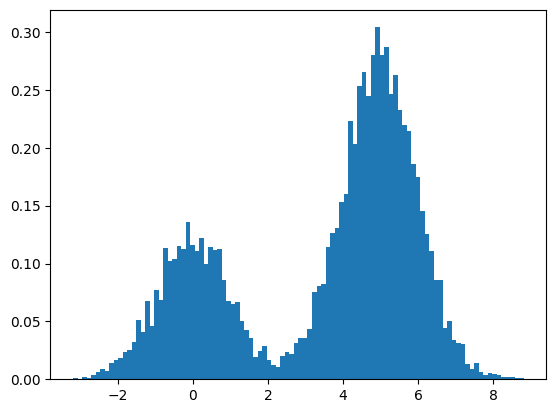

In [2]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)


def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)


x = sampling(n)
plt.hist(x, bins=100, density=True);

このような多峰性のある分布には混合ガウス分布を仮定する事が一般的。  
上記の場合二つの峰が見られるので、二つのガウス分布が混ざった分布を仮定できそう。

混合ガウス分布のパラメータは、各ガウス分布のパラメータ（平均と分散）、そしてそれらの比率を表す混合比率である。これらのパラメータを EM アルゴリズムによって推定するのだが、今回の例題では各ガウス分布のパラメータを既知とし、混合比率のみを推定する問題とする。少し特殊な例だが、シンプルな例題として。

この分布の正解は以下である。

$$
\begin{align}

p(x) &= 0.3 \mathcal{N}_0(x) + 0.7 \mathcal{N}_1(x) \\
\mathcal{N}_0 &= \mathcal{N}(\mu=0, \sigma=1) \\
\mathcal{N}_1 &= \mathcal{N}(\mu=5, \sigma=1) \\

\end{align}
$$

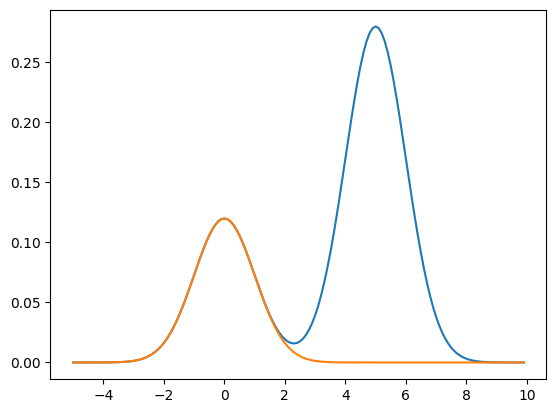

In [3]:
norm = [dist.Normal(0, 1), dist.Normal(5, 1)]
theta = 0.7

pi = [1 - theta, theta]
x_ = torch.arange(-5, 10, 0.1)
y = torch.stack([p * n.log_prob(x_).exp() for n, p in zip(norm, pi)])
y[1] += y[0]
plt.plot(x_, y.T.flip(-1));

この混合比率（7:3）を未知と仮定し、これを推定する。

まずは比率を表すパラメータを導入しよう。$\mathcal N_1$の割合を$\theta$とし、以下のように表す。

$$
p(x;\theta) = (1-\theta) \mathcal{N}_0(x) + \theta \mathcal{N}_1(x)
$$

$\theta=0.7$が正解。これをEMアルゴリズムで推定する。


EMアルゴリズムでは、まず潜在変数を導入する。混合ガウス分布では、サンプルがどのガウス分布から得られたかを表すカテゴリ変数を潜在変数とする。今回は二つのガウス分布が混ざっているので、サンプル$x^{(i)}$がそのどちらから得られたかを表す潜在変数$z^{(i)}\in\{0,1\}$を導入する。すると、同時分布を以下のように定義できる。

$$
\begin{align}

p(x,z;\theta)
    &= p(x| z; \theta)p(z; \theta) \\
    &= \mathcal N_{z}(x) \text{Bern}(z; \theta)

\end{align}
$$

$p(z;\theta)$はベルヌーイ分布$\text{Bern}(z;\theta)$で、確率$\theta$で$z=1$となる。$p(x|z;\theta)$は$z$に対応するガウス分布$\mathcal N_z(x)$。

実際にこれを周辺化すると先のモデルと一致する。

$$
\begin{align}

p(x; \theta)
    &= \sum_z p(x, z; \theta) \\
    &= \sum_z \mathcal N_z(x) \text{Bern}(z; \theta) \\
    &= (1 - \theta) \mathcal N_0(x) + \theta \mathcal N_1(x)

\end{align}
$$

では、この同時分布の期待値を求めよう。

$$
\begin{align}

\mathcal Q(\theta, \theta_{old})
    &= \mathbb E_{p(Z|X;\theta_{old})} [ \, \log p(X, Z; \theta) \, ] \\
    &= \mathbb E_{p(Z|X;\theta_{old})} \left[ \sum_i \log p(x^{(i)}, z^{(i)}; \theta) \right] \\
    &= \sum_i \mathbb E_{p(z^{(i)}|x^{(i)};\theta_{old})} \left[ \, \log p(x^{(i)}, z^{(i)}; \theta) \, \right] \\
    &= \sum_i \mathbb E_{p(z^{(i)}|x^{(i)};\theta_{old})} \left[ \, \log \left( \mathcal N_{z^{(i)}}(x^{(i)})\text{Bern}(z^{(i)}; \theta) \right) \, \right] \\
    &= \sum_i \mathbb E_{p(z^{(i)}|x^{(i)};\theta_{old})} \left[ \, \log \mathcal N_{z^{(i)}}(x^{(i)}) + \log \text{Bern}(z^{(i)}; \theta) \, \right] \\
    &= \sum_i \mathbb E_{p(z^{(i)}|x^{(i)};\theta_{old})} \left[ \, \log \text{Bern}(z^{(i)}; \theta) \, \right] + \text{const}

\end{align}
$$

後程$\theta$で偏微分するため、$\theta$に関係のないガウス分布の項は定数として無視する。

引き続き変形していく。$\Sigma$の中を計算する。

$$
\begin{align}

\mathbb E_{p(z^{(i)}| x^{(i)}; \theta_{old})} \Big[ \log \text{Ber}(z^{(i)}; \theta) \Big]
    &= \sum_{z^{(i)}} p(z^{(i)}| x^{(i)}; \theta_{old}) \log \text{Ber}(z^{(i)}; \theta) \\
    &= p(z^{(i)}=0| x^{(i)}; \theta_{old}) \log \text{Ber}(0; \theta) + p(z^{(i)}=1| x^{(i)}; \theta_{old}) \log \text{Ber}(1; \theta) \\
    &= r_0^{(i)} \log (1 - \theta) + r_1^{(i)} \log (\theta)

\end{align}
$$

$p(z^{(i)}=k|x^{(i)};\theta_{old})$は$r_k^{(i)}$と表した。これは負担率とも呼ばれ、$x^{(i)}$が得られた下で$z^{(i)}=k$となる事後確率を意味する。ベイズの定理によって求められる。

$$
\begin{align}

r_k^{(i)}
    &= p(k| x^{(i)}; \theta_{old}) \\
    &= \frac{p(x^{(i)}| k) p(k; \theta_{old})}{\sum_{k'} p(x^{(i)}| k') p(k'; \theta_{old})} \\
    &= \frac{\mathcal N_k(x^{(i)}) \text{Bern}(k;\theta_{old})}{\sum_{k'=0}^1 \mathcal N_{k'}(x^{(i)}) \text{Bern}(k'; \theta_{old})}

\end{align}
$$


では、$\mathcal Q$を$\theta$で偏微分していく。

$$
\begin{align}
\frac{\partial\mathcal Q}{\partial\theta}
    &= \frac{\partial}{\partial\theta}\sum_i\big(r_0^{(i)}\log(1-\theta) + r_1^{(i)}\log(\theta)\big) \\
    &= \sum_i\frac{\partial}{\partial\theta}\big(r_0^{(i)}\log(1-\theta)\big) + \sum_i\frac{\partial}{\partial\theta}\big(r_1^{(i)}\log(\theta)\big) \\
    &= \sum_i\frac{r_1^{(i)}}{\theta} - \sum_i\frac{r_0^{(i)}}{1-\theta} \\
\end{align}
$$

これが 0 になるときの$\theta$を計算すると、以下となる。

$$
\theta = \frac{\sum_i r_1^{(i)}}{\sum_i r_0^{(i)} + \sum_i r_1^{(i)}}
$$


ということで、ある$\theta$の下で対数尤度を大きくする新たな$\theta$が求められるようになった。この更新を繰り返す事で、対数尤度を最大にする$\theta$が近似できる。

実装してみよう。

まず$\theta$を初期化する。ランダムで。

In [4]:
theta = random.random()
theta

0.23821156706414648

次に$\theta$の更新式を書く。ある$\theta$を受け取って、より対数尤度が大きくなる新たな$\theta$を返す関数を書く。


In [5]:
def return_new_theta(theta, X):
    # 事後分布の尤度
    j0 = (1 - theta) * norm0.log_prob(X).exp()  # p(0|x;theta)
    j1 = theta * norm1.log_prob(X).exp()  # p(1|x;theta)

    # 負担率の和
    r0 = (j0 / (j1 + j0)).sum()  # sum_i r^i_0
    r1 = (j1 / (j1 + j0)).sum()  # sum_i r^i_1

    return (r1 / (r1 + r0)).item()

では、何回か更新をしてみる


In [6]:
for _ in range(10):
    print(theta)
    theta = return_new_theta(theta, x)

0.23821156706414648
0.6870362758636475
0.697598934173584
0.6978197693824768
0.6978243589401245
0.6978245377540588
0.6978245377540588
0.6978245377540588
0.6978245377540588
0.6978245377540588


正解である$\theta=0.7$に近づいた。



---

## 混合ガウス分布

GMM: *Gaussian Mixture Model*

割合だけでなく、各ガウス分布の平均と分散も推定する。また多変量ガウス分布に拡張する。

例えば、以下のようなサンプルが得られたとする。

In [ ]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.mu = None
        self.sigma = None
        self.pi = None

    def fit(self, X):
        N, d = X.shape
        self._init_params(d)

        for _ in range(self.max_iter):
            gamma = self._get_gamma(X)
            Nk = gamma.sum(axis=1)

            mu = gamma @ X / Nk.reshape(-1, 1)
            sigma = np.array([
                ((X - muk).T * gammak) @ (X - muk)
                for muk, gammak in zip(self.mu, gamma)
            ]) / Nk.reshape(-1, 1, 1)

            # sigma = []
            # for k in range(self.n_components):
            #     g = gamma[k]
            #     m = self.mu[k]
            #     sigmak = (g.reshape(-1, 1, 1) * np.array([(x - m).reshape(-1, 1) @ (x - m).reshape(1, -1) for x in X])).sum(0)
                
            #     sigma.append(sigmak)

            # print(Nk.shape)
            self.mu = mu
            self.sigma = np.array(sigma)# / Nk.reshape(-1, 1, 1)
            self.pi = Nk / N
            # print(self.mu.shape, self.sigma.shape, self.pi.shape)

    def predict(self, X):
        gamma = self._get_gamma(X)
        c = gamma.argmax(axis=0)
        return c

    def _init_params(self, d):
        self.mu = np.random.randn(self.n_components, d)
        self.sigma = np.array([np.eye(d) for _ in range(self.n_components)])
        self.pi = np.random.rand(self.n_components)
        self.pi /= self.pi.max()

    def _get_gamma(self, X):
        joint_probs = []
        for mu, sigma, pi in zip(self.mu, self.sigma, self.pi):
            likelihood = sp.stats.multivariate_normal.pdf(X, mean=mu, cov=sigma)
            joint_prob = pi * likelihood
            joint_probs.append(joint_prob)
        joint_probs = np.array(joint_probs)
        gamma = joint_probs / joint_probs.sum(axis=0) # (K, N)
        return gamma

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
from sklearn.datasets import make_blobs

In [3]:
N = 500
d = 2
K = 3

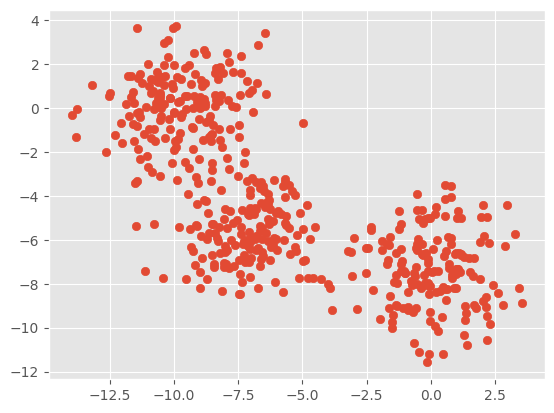

In [4]:
X, y = make_blobs(
    n_samples=N,
    n_features=d,
    centers=K,
    cluster_std=1.5,
    random_state=9,
)
plt.scatter(X[:, 0], X[:, 1]);

In [12]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.mu = None
        self.sigma = None
        self.pi = None

    def fit(self, X):
        N, d = X.shape
        self._init_params(d)

        for _ in range(self.max_iter):
            gamma = self._posterior_prod(X)
            Nk = gamma.sum(axis=1)

            self.mu = gamma @ X / Nk.reshape(-1, 1)

            dev = np.array([X - self.mu[k] for k in range(self.n_components)])
            dev_gamma = (gamma[..., np.newaxis] * dev).transpose(0, 2, 1)
            self.sigma = dev_gamma @ dev / Nk.reshape(-1, 1, 1)

            self.pi = Nk / N

    def predict(self, X):
        gamma = self._posterior_prod(X)
        c = gamma.argmax(axis=0)
        return c

    def _init_params(self, d):
        self.mu = np.random.randn(self.n_components, d) # (K, d)
        self.sigma = np.tile(np.eye(d), (self.n_components, 1, 1)) # (K, d, d)
        self.pi = np.ones(self.n_components) / self.n_components # (K,)

    def _posterior_prod(self, X):
        joint_probs = []
        for mu, sigma, pi in zip(self.mu, self.sigma, self.pi):
            likelihood = sp.stats.multivariate_normal.pdf(X, mean=mu, cov=sigma)
            joint_prob = pi * likelihood
            joint_probs.append(joint_prob)
        joint_probs = np.array(joint_probs)
        gamma = joint_probs / joint_probs.sum(axis=0) # (K, N)
        return gamma

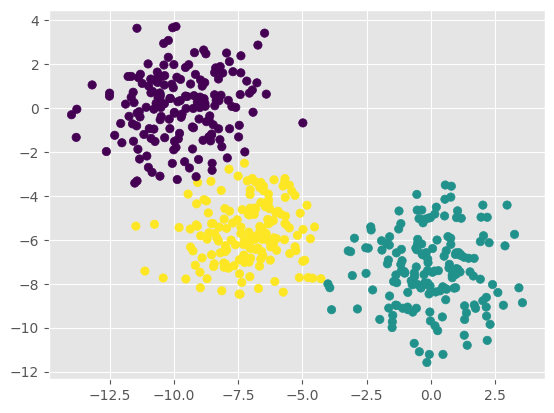

In [13]:
gmm = GaussianMixture(n_components=K)
gmm.fit(X)
clusters = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters);

In [98]:
from sklearn.mixture import GaussianMixture as CorrectGMM

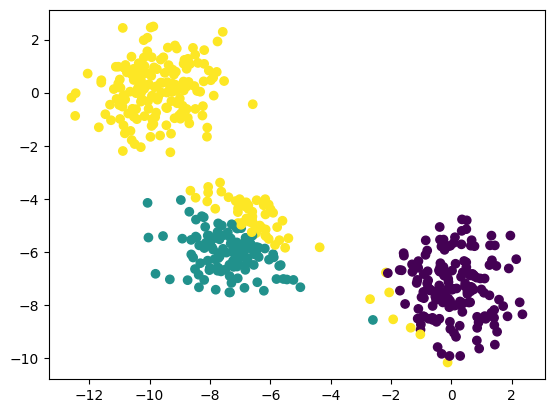

In [144]:
gmm = CorrectGMM(K, init_params="random")
gmm.fit(X)
clusters = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters);

ここから、各ガウス分布の平均、共分散行列、混合比率を推定する。クラスタ数（ガウス分布の数）だけはこちらで仮定する必要がある。

まず、モデル化していく。

$$
p(\boldsymbol x;\theta) = \sum_{k=1}^K \pi_k \mathcal N_k(\boldsymbol x)
$$

$K$はクラスタ数。

$\mathcal N_k(\boldsymbol x)$は$k$番目のガウス分布で、それぞれがパラメータとして平均$\boldsymbol\mu_k$と共分散行列$\Sigma_k$を持つ。

$$
\mathcal N_k(\boldsymbol x) = \mathcal N(\boldsymbol x;\boldsymbol\mu_k, \Sigma_k)
$$

$\pi_k$は$k$番目のガウス分布の混合比率で、これもパラメータの一つ。比率$\pi_k$の総和は1でないといけない。

$$
\sum_{k=1}^K \pi_k = 1
$$

先ほど同様、同時分布を定義し、潜在変数を導入する。

$$
\begin{align}

p(x,z;\theta)
    &= p(x|z;\theta)p(z;\theta) \\
    &= \mathcal N_{z}(x) \pi_z \\

\end{align}
$$

期待値。

$$
\begin{align}

\mathcal Q(\theta, \theta_{old})
    &= \mathbb E_{p(Z|X;\theta_{old})} [ \, \log p(X, Z| \theta) \, ] \\
    &= \sum_i \mathbb E_{p(z^{(i)}| x^{(i)}; \theta_{old})} \left[ \, \log p(x^{(i)}, z^{(i)} | \theta) \, \right] \\
    &= \sum_i \mathbb E_{p(z^{(i)}| x^{(i)}; \theta_{old})} \left[ \, \log \mathcal N_{z^{(i)}}(x^{(i)}) + \log \pi_{z^{(i)}} \, \right] \\
    &= \sum_i \sum_k p(z_{(i)}=k| x^{(i)}; \theta_{old}) \left( \log \mathcal N_k(x^{(i)}) + \log \pi_k \right) \\
    &= \sum_i \sum_k r_k^{(i)} \left( \log \mathcal N_k(x^{(i)}) + \log \pi_k \right) \\
    &= \sum_i \sum_k r_k^{(i)} \left( -\frac{1}{2} \Big( d \log(2\pi) + \log |\Sigma| + (\boldsymbol x - \boldsymbol\mu)^T \Sigma^{-1} (\boldsymbol x - \boldsymbol\mu) \Big) + \log \pi_k \right) \\

\end{align}
$$

最後は

$$
\begin{align}

\log \mathcal N(\boldsymbol x; \boldsymbol\mu, \Sigma)
    &= \log \left( \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp \left( -\frac{1}{2} (\boldsymbol x - \boldsymbol\mu)^T \Sigma (\boldsymbol x - \boldsymbol\mu) \right) \right) \\
    &= -\frac{1}{2} \log \Big( (2\pi)^d |\Sigma| \Big) -\frac{1}{2} (\boldsymbol x - \boldsymbol\mu)^T \Sigma^{-1} (\boldsymbol x - \boldsymbol\mu) \\
    &= -\frac{1}{2} \Big( d \log(2\pi) + \log |\Sigma| + (\boldsymbol x - \boldsymbol\mu)^T \Sigma^{-1} (\boldsymbol x - \boldsymbol\mu) \Big)

\end{align}
$$

各パラメータで微分していく。

$$
\begin{align}

\frac{\partial \mathcal Q}{\partial \boldsymbol\mu_k}
    &= \sum_i r_k^{(i)} \frac{1}{\pi_k} \\

\end{align}
$$